In [ ]:
#Shuvani Choudhury (12768553)
#Purpose of code: Fit MM-ARX-EGARCH models and find those with significant asymmetry

In [57]:
#Import relevant packages
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from arch.univariate import EGARCH
from arch import arch_model
from statsmodels.compat import lzip
from scipy import stats
import arch
from statsmodels.stats.diagnostic import het_white
from statistics import stdev
from arch.univariate import LS
from arch.univariate import ARX
from arch.univariate import HARX
from scipy.stats import ttest_1samp
from pylab import *
from tikzplotlib import save as tikz_save

In [58]:
#Read excel file and calculate the log-returns(*10 to make more accurate predictions)
#Rescaling will not be significant as the purpose of this code is to find the time-series with significant asymmetry
df = pd.read_excel('data.xlsx', index_col=0)
df['log_ret_USA'] = 1000*(np.log(df.USA) - np.log(df.USA.shift(1)))
df['log_ret_JAP'] = 1000*(np.log(df.Japan) - np.log(df.Japan.shift(1)))
df['log_ret_NL'] = 1000*(np.log(df.Netherlands) - np.log(df.Netherlands.shift(1)))
df['log_ret_GER'] = 1000*(np.log(df.Germany) - np.log(df.Germany.shift(1)))
df['log_ret_BR'] = 1000*(np.log(df.Brazil) - np.log(df.Brazil.shift(1)))
df['log_ret_HK'] = 1000*(np.log(df.HK) - np.log(df.HK.shift(1)))
df['log_ret_SA'] = 1000*(np.log(df.SA) - np.log(df.SA.shift(1)))
df['log_ret_SK'] = 1000*(np.log(df.SK) - np.log(df.SK.shift(1)))
df['log_ret_AU'] = 1000*(np.log(df.Australia) - np.log(df.Australia.shift(1)))
df['log_ret_IND'] = 1000*(np.log(df.India) - np.log(df.India.shift(1)))
df['log_ret_MSCI'] = 1000*(np.log(df.MSCI) - np.log(df.MSCI.shift(1)))
df.head()

USA         Japan  Netherlands    Germany   Brazil  \
Date                                                                       
Dec 03, 2018  2790.370117  22574.759766   523.869995  25.966000  89820.0   
Dec 04, 2018  2700.060059  22036.050781   523.229980  25.200001  88624.0   
Dec 06, 2018  2695.949951  21501.619141   498.920013  24.910000  88846.0   
Dec 07, 2018  2633.080078  21678.679688   503.980011  24.444000  88115.0   
Dec 10, 2018  2637.719971  21219.500000   495.309998  24.350000  85915.0   

                        HK            SA           SK  Australia  \
Date                                                               
Dec 03, 2018  27182.039063  10209.959961  2131.929932  54.180000   
Dec 04, 2018  27260.439453  10263.990234  2114.350098  53.660000   
Dec 06, 2018  26156.380859   9893.459961  2068.689941  53.099998   
Dec 07, 2018  26063.759766   9946.290039  2075.760010  53.349998   
Dec 10, 2018  25752.380859   9754.330078  2053.790039  52.169998   

                     India  ...  log_ret_JAP  log_ret_NL  log_ret_GER  \
Date                        ...                                         
Dec 03, 2018  36241.000000  ...          NaN         NaN          NaN   
Dec 04, 2018  36134.308594  ...   -24.152674   -1.222453   -29.943956   
Dec 06, 2018  35312.128906  ...   -24.551543  -47.575311   -11.574705   
Dec 07, 2018  35673.250000  ...     8.201034   10.090818   -18.884542   
Dec 10, 2018  34959.718750  ...   -21.408704  -17.352781    -3.852938   

              log_ret_BR  log_ret_HK  log_ret_SA  log_ret_SK  log_ret_AU  \
Date                                                                       
Dec 03, 2018         NaN         NaN         NaN         NaN         NaN   
Dec 04, 2018  -13.404966    2.880120    5.277965   -8.280158   -9.643992   
Dec 06, 2018    2.501833  -41.343376  -36.767747  -21.831955  -10.490954   
Dec 07, 2018   -8.261754   -3.547336    5.325692    3.411828    4.697050   
Dec 10, 2018  -25.284344  -12.018751  -19.488324  -10.640471  -22.366362   

              log_ret_IND  log_ret_MSCI  
Date                                     
Dec 03, 2018          NaN           NaN  
Dec 04, 2018    -2.948284    -21.697498  
Dec 06, 2018   -23.016291    -15.741937  
Dec 07, 2018    10.174608    -10.900243  
Dec 10, 2018   -20.204602     -8.213599  

[5 rows x 22 columns]

In [59]:
#SPlit the dataset into training and test subsets
df_tr=df.iloc[:186].dropna()
df_test=df.iloc[186:].dropna()
ret_test=df_test.iloc[:,11:21]
mkt_tr=df_tr.iloc[:,21].dropna()
print(mkt_tr)

Date
Dec 04, 2018   -21.697498
Dec 06, 2018   -15.741937
Dec 07, 2018   -10.900243
Dec 10, 2018    -8.213599
Dec 11, 2018     0.998213
Dec 12, 2018    11.392488
Dec 13, 2018     0.159086
Dec 14, 2018   -15.841280
Dec 18, 2018   -16.753431
Dec 19, 2018    -6.264652
Dec 20, 2018   -15.062935
Dec 21, 2018   -13.351784
Dec 27, 2018    11.940541
Dec 28, 2018     5.398984
Jan 04, 2019    15.629207
Jan 07, 2019     8.883120
Jan 08, 2019     6.862150
Jan 09, 2019     9.162537
Jan 10, 2019     3.494433
Jan 11, 2019    -0.032004
Jan 15, 2019     3.291001
Jan 16, 2019     1.721061
Jan 17, 2019     3.877452
Jan 18, 2019    12.169896
Jan 22, 2019   -10.395104
Jan 23, 2019     0.728021
Jan 24, 2019     2.338739
Jan 29, 2019     3.843856
Jan 30, 2019     9.856921
Jan 31, 2019     9.267218
                  ...    
Sep 26, 2019     0.116164
Sep 27, 2019    -4.015485
Sep 30, 2019     1.602308
Oct 04, 2019   -11.005526
Oct 10, 2019    -1.325303
Oct 11, 2019    13.552683
Oct 15, 2019     7.992398
Oct 16,

       log_ret_USA  log_ret_JAP  log_ret_NL  log_ret_GER  log_ret_BR  \
count   181.000000   181.000000  181.000000   181.000000  181.000000   
mean      0.675182     0.132076    0.763804     0.291414    1.070346   
std       9.370561    10.995784    9.463269    12.722564   13.035123   
min     -32.900229   -30.526434  -47.575311   -51.506242  -44.914106   
25%      -2.948697    -5.314118   -2.848777    -5.379249   -5.818091   
50%       1.231104     0.540459    1.400087     0.273421    2.237065   
75%       5.736340     5.882414    6.642114     7.571305    9.003250   
max      29.442834    38.249620   29.263534    52.436006   44.006923   

       log_ret_HK  log_ret_SA  log_ret_SK  log_ret_AU  log_ret_IND  
count  181.000000  181.000000  181.000000  181.000000   181.000000  
mean    -0.223393    0.040137   -0.138671    0.707661     0.500097  
std     11.730449   10.891741    9.387711    8.643369    10.002135  
min    -41.343376  -36.767747  -35.049150  -27.961173   -26.043160  
25%   

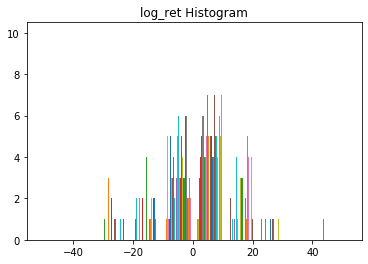

In [60]:
#Seperate the stock indices' returns from their prices
df_tr2=df_tr.iloc[:,11:21].dropna()
df_test2=df_test.iloc[:,11:21].dropna()

#Calculate and print descriptive statistics
print(df_tr2.describe())
print(df_tr2.kurtosis());
print(df_tr2.skew());
plt.hist(df_tr2,);
plt.title('log_ret Histogram');

In [61]:
#Make structural changes to the exogenous variable for syntax purposes
mkt_tr2 = np.array(mkt_tr.values.tolist());
mkt_tr2 = mkt_tr2.reshape(len(mkt_tr2), 1);

In [62]:
#Fit relevant mean models to each time-series
ls_USA = ARX(df_tr2.log_ret_USA, mkt_tr2, lags=[1,3,4,7,9,10,11,13], constant=True);
ls_JAP = ARX(df_tr2.log_ret_JAP, mkt_tr2, lags=[1,4,6,8,9,10,11,12,13,14,15], constant=True);
ls_NL = ARX(df_tr2.log_ret_NL, mkt_tr2, lags=[11,14], constant=True);
ls_GER = ARX(df_tr2.log_ret_GER, mkt_tr2, lags=[5,6], constant=True);
ls_BR = LS(df_tr2.log_ret_BR, mkt_tr2, constant=True);
ls_HK = ARX(df_tr2.log_ret_HK, mkt_tr2, lags=[1,3,8], constant=True);
ls_SA = ARX(df_tr2.log_ret_SA, mkt_tr2, lags=1, constant=True);
ls_SK = ARX(df_tr2.log_ret_SK, mkt_tr2, lags=5, constant=True);
ls_AU = ARX(df_tr2.log_ret_AU, mkt_tr2, lags=[2,3,4,5,6,7,8,9,10,11,12], constant=True);
ls_IND = LS(df_tr2.log_ret_IND, mkt_tr2, constant=True);

In [67]:
#Fit relevant volatility models to each time series (check which ones have significant gamma parameters/asymmetry)
ls_USA.distibution = 'StudentsT';
ls_USA.volatility = EGARCH(p=5,q=1,o=1);
res_USA = ls_USA.fit(update_freq=0, disp='off');
print(res_USA.summary());
ls_JAP.distibution = 'StudentsT';
ls_JAP.volatility = EGARCH(p=20,q=0,o=1);
res_JAP = ls_JAP.fit(update_freq=0, disp='off');
print(res_JAP.summary());
ls_NL.distibution = 'StudentsT'; #requires individual scaling of 1000000*y to converge
ls_NL.volatility = EGARCH(p=2, q=0,o=1);
res_NL = ls_NL.fit(update_freq=0, disp='off',options={'maxiter': 1000000,'ftol': 1e-4});
print(res_NL.summary());
ls_GER.distibution = 'StudentsT'; #had to be changed to remain stationary despite gamma
ls_GER.volatility = EGARCH(p=1,q=0,o=1);
res_GER = ls_GER.fit(update_freq=0, disp='off');
print(res_GER.summary());
ls_BR.distibution = 'StudentsT';
ls_BR.volatility = EGARCH(p=1,q=0,o=1);
res_BR = ls_BR.fit(update_freq=0, disp='off');
print(res_BR.summary());
ls_HK.distibution = 'StudentsT';
ls_HK.volatility = EGARCH(p=8,q=2,o=1);
res_HK = ls_HK.fit(update_freq=0, disp='off');
print(res_HK.summary());
ls_SA.distibution = 'StudentsT';
ls_SA.volatility = EGARCH(p=3,q=2,o=1);
res_SA = ls_SA.fit(update_freq=0, disp='off');
print(res_SA.summary());
ls_SK.distibution = 'StudentsT'; #had to be changed to remain stationary despite gamma, has significant positive result
ls_SK.volatility = EGARCH(p=1,q=1,o=1);
res_SK = ls_SK.fit(update_freq=0, disp='off');
print(res_SK.summary());
ls_AU.distibution = 'Normal'; #had to be changed to remain stationary despite gamma, has significant negative result
ls_AU.volatility = EGARCH(p=2,q=1,o=1);
res_AU = ls_AU.fit(update_freq=0, disp='off');
print(res_AU.summary());
ls_IND.distibution = 'Normal'; #has significant negative result
ls_IND.volatility = EGARCH(p=3,q=0,o=1);
res_IND = ls_IND.fit(update_freq=0, disp='off');
print(res_IND.summary());

                         AR-X - EGARCH Model Results                          
Dep. Variable:            log_ret_USA   R-squared:                       0.904
Mean Model:                      AR-X   Adj. R-squared:                  0.898
Vol Model:                     EGARCH   Log-Likelihood:               -381.943
Distribution:                  Normal   AIC:                           799.885
Method:            Maximum Likelihood   BIC:                           856.117
                                        No. Observations:                  168
Date:                Sun, Aug 09 2020   Df Residuals:                      150
Time:                        16:13:56   Df Model:                           18
                                     Mean Model                                    
                      coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------------
Const               0.4700  1.907e-02

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:605: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                          AR-X - EARCH Model Results                          
Dep. Variable:            log_ret_JAP   R-squared:                       0.265
Mean Model:                      AR-X   Adj. R-squared:                  0.207
Vol Model:                      EARCH   Log-Likelihood:               -544.191
Distribution:                  Normal   AIC:                           1158.38
Method:            Maximum Likelihood   BIC:                           1267.30
                                        No. Observations:                  166
Date:                Sun, Aug 09 2020   Df Residuals:                      131
Time:                        16:13:57   Df Model:                           35
                                    Mean Model                                    
                     coef    std err          t      P>|t|        95.0% Conf. Int.
----------------------------------------------------------------------------------
Const              1.4415  2.488e-02    

                         AR-X - EGARCH Model Results                          
Dep. Variable:             log_ret_HK   R-squared:                       0.384
Mean Model:                      AR-X   Adj. R-squared:                  0.369
Vol Model:                     EGARCH   Log-Likelihood:               -611.969
Distribution:                  Normal   AIC:                           1257.94
Method:            Maximum Likelihood   BIC:                           1311.54
                                        No. Observations:                  173
Date:                Sun, Aug 09 2020   Df Residuals:                      156
Time:                        16:13:57   Df Model:                           17
                                    Mean Model                                   
                    coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------------
Const            -0.5096  2.020e-02    -25.

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:605: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


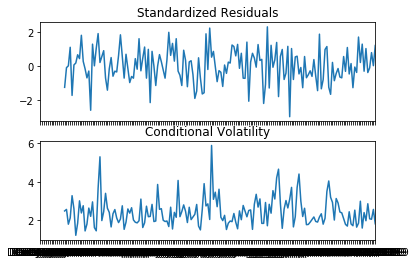

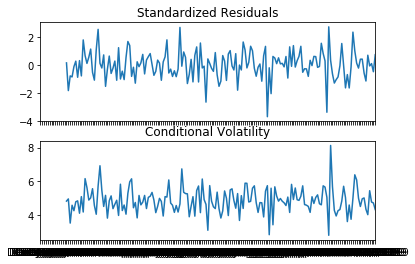

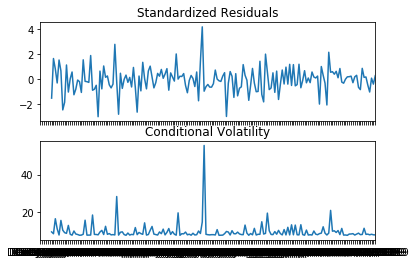

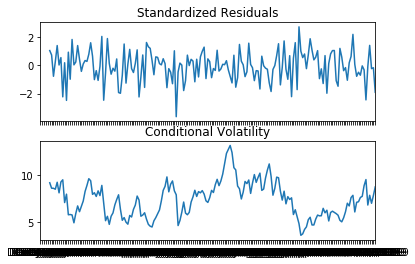

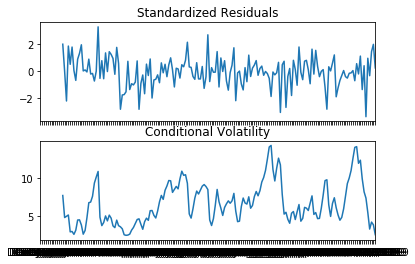

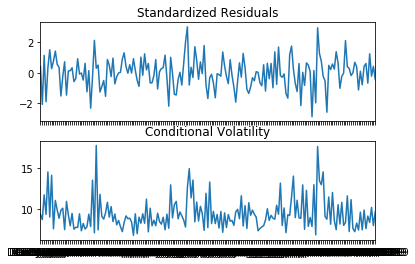

In [68]:
#Check models' residuals and conditional volatilities for mean-reversion and trends
fig_USA=res_USA.plot()
fig_JAP=res_JAP.plot()
fig_NL=res_NL.plot()
fig_GER=res_GER.plot()
fig_BR=res_BR.plot()
fig_HK=res_HK.plot()
fig_SA=res_SA.plot()
fig_SK=res_SK.plot()
fig_AU=res_AU.plot()
fig_IND=res_IND.plot()

In [69]:
#Fit and print correlograms for models (split into 2 figures to make it easier to save and upload to latex file later)
fig,ax = plt.subplots(nrows=7, ncols=2, figsize=(32,49));
tsaplots.plot_acf(res_USA.resid.dropna()**2, lags=50, zero=False, ax = ax[0][0])
ax[0][0].set_title('resid^2_USA')
ax[0][0].set_ylabel(r'$\rho_\ell$')
ax[0][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_USA.resid.dropna()**2, lags=50, zero=False, ax = ax[0][1])
ax[0][1].set_ylabel(r'$\rho_\ell$')
ax[0][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(res_JAP.resid.dropna()**2, lags=50, zero=False, ax = ax[1][0])
ax[1][0].set_title('resid^2_JAP')
ax[1][0].set_ylabel(r'$\rho_\ell$')
ax[1][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_JAP.resid.dropna()**2, lags=50, zero=False, ax = ax[1][1])
ax[1][1].set_ylabel(r'$\rho_\ell$')
ax[1][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(res_NL.resid.dropna()**2, lags=50, zero=False, ax = ax[2][0])
ax[2][0].set_title('resid^2_NL')
ax[2][0].set_ylabel(r'$\rho_\ell$')
ax[2][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_NL.resid.dropna()**2, lags=50, zero=False, ax = ax[2][1])
ax[2][1].set_ylabel(r'$\rho_\ell$')
ax[2][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(res_GER.resid.dropna()**2, lags=50, zero=False, ax = ax[3][0])
ax[3][0].set_title('resid^2_GER')
ax[3][0].set_ylabel(r'$\rho_\ell$')
ax[3][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_GER.resid.dropna()**2, lags=50, zero=False, ax = ax[3][1])
ax[3][1].set_ylabel(r'$\rho_\ell$')
ax[3][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(res_BR.resid.dropna()**2, lags=50, zero=False, ax = ax[4][0])
ax[4][0].set_title('resid^2_BR')
ax[4][0].set_ylabel(r'$\rho_\ell$')
ax[4][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_BR.resid.dropna()**2, lags=50, zero=False, ax = ax[4][1])
ax[4][1].set_ylabel(r'$\rho_\ell$')
ax[4][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(res_HK.resid.dropna()**2, lags=50, zero=False, ax = ax[5][0])
ax[5][0].set_title('resid^2_HK')
ax[5][0].set_ylabel(r'$\rho_\ell$')
ax[5][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_HK.resid.dropna()**2, lags=50, zero=False, ax = ax[5][1])
ax[5][1].set_ylabel(r'$\rho_\ell$')
ax[5][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(res_SA.resid.dropna()**2, lags=50, zero=False, ax = ax[6][0])
ax[6][0].set_title('resid^2_SA')
ax[6][0].set_ylabel(r'$\rho_\ell$')
ax[6][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_SA.resid.dropna()**2, lags=50, zero=False, ax = ax[6][1])
ax[6][1].set_ylabel(r'$\rho_\ell$')
ax[6][1].set_xlabel(r'$\ell$');
tikz_save('correlogramsE1.tikz')

fig,ax = plt.subplots(nrows=3, ncols=2, figsize=(32,21));
tsaplots.plot_acf(res_SK.resid.dropna()**2, lags=50, zero=False, ax = ax[0][0])
ax[0][0].set_title('resid^2_SK')
ax[0][0].set_ylabel(r'$\rho_\ell$')
ax[0][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_SK.resid.dropna()**2, lags=50, zero=False, ax = ax[0][1])
ax[0][1].set_ylabel(r'$\rho_\ell$')
ax[0][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(res_AU.resid.dropna()**2, lags=50, zero=False, ax = ax[1][0])
ax[1][0].set_title('resid^2_AU')
ax[1][0].set_ylabel(r'$\rho_\ell$')
ax[1][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_AU.resid.dropna()**2, lags=50, zero=False, ax = ax[1][1])
ax[1][1].set_ylabel(r'$\rho_\ell$')
ax[1][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(res_IND.resid.dropna()**2, lags=50, zero=False, ax = ax[2][0])
ax[2][0].set_title('resid^2_IND')
ax[2][0].set_ylabel(r'$\rho_\ell$')
ax[2][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(res_IND.resid.dropna()**2, lags=50, zero=False, ax = ax[2][1])
ax[2][1].set_ylabel(r'$\rho_\ell$')
ax[2][1].set_xlabel(r'$\ell$');
tikz_save('correlogramsE2.tikz')

In [70]:
#Test models for residual autocorrelation (Ljung-Box test)
name = ['LB Test', 'p-value', 'F-version', 'F p-value'];
stand_resid_USA = res_USA.resid.dropna()/res_USA.conditional_volatility.dropna();
stand_resid_JAP = res_JAP.resid.dropna()/res_JAP.conditional_volatility.dropna();
stand_resid_NL = res_NL.resid.dropna()/res_NL.conditional_volatility.dropna();
stand_resid_GER = res_GER.resid.dropna()/res_GER.conditional_volatility.dropna();
stand_resid_BR = res_BR.resid.dropna()/res_BR.conditional_volatility.dropna();
stand_resid_HK = res_HK.resid.dropna()/res_HK.conditional_volatility.dropna();
stand_resid_SA = res_SA.resid.dropna()/res_SA.conditional_volatility.dropna();
stand_resid_SK = res_SK.resid.dropna()/res_SK.conditional_volatility.dropna();
stand_resid_AU = res_AU.resid.dropna()/res_AU.conditional_volatility.dropna();
stand_resid_IND = res_IND.resid.dropna()/res_IND.conditional_volatility.dropna();

test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_USA); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_JAP); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_NL); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_GER); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_BR); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_HK); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_SA); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_SK); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_AU); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_IND); #0lags
print(lzip(name, test));

[('LB Test', array([ 2.0702418 ,  3.30219586,  3.54802819,  4.03473277,  5.07862257,
       11.47739383, 13.11852125, 14.57888798, 14.57919875, 14.68244044,
       16.46045845, 17.54747551, 19.57789368, 19.71887865, 19.72043629,
       20.48191578, 22.88560538, 22.91526259, 26.22692686, 26.27202511,
       26.60819401, 28.02519444, 28.0276634 , 28.09476333, 28.79272776,
       29.01553136, 29.21314974, 29.21561389, 33.34892915, 34.73070534,
       34.93886866, 35.81257823, 37.46801126, 37.5195665 , 37.64915861,
       42.20514607, 42.60203142, 43.34352737, 43.55644133, 43.55687049])), ('p-value', array([0.15019771, 0.19183917, 0.31458624, 0.40132569, 0.4063606 ,
       0.07469603, 0.06927276, 0.06786983, 0.10316229, 0.14407554,
       0.12487895, 0.13013744, 0.10624674, 0.1392566 , 0.18292139,
       0.19929504, 0.15301203, 0.19386743, 0.12398909, 0.15701453,
       0.18420121, 0.17484775, 0.21473733, 0.25606317, 0.27267332,
       0.31037637, 0.35063993, 0.40165342, 0.26388944, 0.2525